<a href="https://www.kaggle.com/code/sagarrathore/skyhack-analysis?scriptVersionId=200209455" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
sns.set_style('whitegrid')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
cmap = 'YlGnBu'
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/calls-skyhack/callsf0d4f5a.csv
/kaggle/input/skyhack-transcriptd/train.csv
/kaggle/input/skyhack-transcriptd/test.csv
/kaggle/input/skyhack-aht-ast/sentiment_statisticscc1e57a.csv
/kaggle/input/skyhack-aht-ast/customers2afd6ea.csv
/kaggle/input/skyhack-aht-ast/testbc7185d.csv
/kaggle/input/skyhack-aht-ast/reason18315ff.csv


# Read Data

In [6]:
date_cols = ['call_start_datetime','agent_assigned_datetime','call_end_datetime']
call = pd.read_csv('/kaggle/input/calls-skyhack/callsf0d4f5a.csv', usecols=['call_id','customer_id','agent_id','call_start_datetime','agent_assigned_datetime','call_end_datetime'],parse_dates=date_cols)
customers = pd.read_csv('/kaggle/input/skyhack-aht-ast/customers2afd6ea.csv')
sentiment_stats = pd.read_csv('/kaggle/input/skyhack-aht-ast/sentiment_statisticscc1e57a.csv')
test = pd.read_csv('/kaggle/input/skyhack-aht-ast/testbc7185d.csv')
reason = pd.read_csv('/kaggle/input/skyhack-aht-ast/reason18315ff.csv')

#Merging Data
callm = pd.merge(call,sentiment_stats, on=['call_id','agent_id'], how='inner')
callm1 = pd.merge(callm,customers, on='customer_id',how='inner')
callm = pd.merge(callm1,reason, on='call_id')

#Test Data
test = pd.merge(test,callm1, on='call_id',how='inner')
num_cols_callm = callm.select_dtypes(include=['number']).columns
cat_cols_callm  = callm.select_dtypes(include=['object']).columns

# Solving Task 1
**
 Long average handle time (AHT) affects both efficiency and customer satisfaction. Explore the factors contributing to extended call durations, such as agent performance, call types, and sentiment. Identify key drivers of long AHT and AST, especially during high volume call periods. Additionally, could you quantify the percentage difference between the average handling time for the most frequent and least frequent call reasons?
**

# Missing Values

In [ ]:
!pip install missingno
import missingno as msno
msnoaggregate.matrix(callm[['agent_tone','average_sentiment','elite_level_code']])


In [ ]:
msno.matrix(callm[['agent_tone','average_sentiment','elite_level_code']])


In [41]:
def summary(df):
    data = pd.DataFrame(index=df.columns)
    data['dtypes'] = df.dtypes
    data['count'] = df.count()
    data['#unique'] = df.nunique()
    return data


In [42]:
summary(callm[['handle_duration','ivr_duration','day','day_of_week','hour']]).style.background_gradient(cmap='YlGnBu')


,dtypes,count,#unique
handle_duration,float64,66653,119
ivr_duration,float64,66653,13
day,int32,66653,31
day_of_week,object,66653,7
hour,int32,66653,24


# Data Preprocessing

In [7]:
#Feature Engineering
from sklearn.impute import SimpleImputer
def feature_engineering(df):
    
    df['handle_duration'] = (df['call_end_datetime']-df['agent_assigned_datetime']).dt.total_seconds()/60 # Agent Duration
    df['ivr_duration'] = (df['agent_assigned_datetime']-df['call_start_datetime']).dt.total_seconds()/60 # IVR Duration
    df['total_duration'] = (df['call_end_datetime']-df['call_start_datetime']).dt.total_seconds()/60 # Total call duration
 
    df['hour'] = df['call_end_datetime'].dt.hour
    df['day_of_week'] = df['call_end_datetime'].dt.day_name()
    df['day'] = df['call_end_datetime'].dt.day
    df['month'] = df['call_end_datetime'].dt.month

    mapping = {
        'Mileage Plus': 'Mileage Plus',
        'Mileage   Plus': 'Mileage Plus',
        'Mileage  Plus': 'Mileage Plus',
        'Mileage Plus  ': 'Mileage Plus',
        'Voluntary Cancel': 'Voluntary Cancel',
        'Voluntary  Cancel': 'Voluntary Cancel',
        'Voluntary Cancel  ': 'Voluntary Cancel',
        'Voluntary Change': 'Voluntary Change',
        'Voluntary  Change': 'Voluntary Change',
        'Voluntary   Change': 'Voluntary Change',
        'Voluntary Change  ': 'Voluntary Change',
        'Booking': 'Booking',
        'Booking  ': 'Booking',
        'IRROPS': 'IRROPS',
        'IRROPS  ': 'IRROPS',
        'Post Flight': 'Post-Flight',
        'Post-Flight  ': 'Post-Flight',
        'Post-Flight': 'Post-Flight',
        'Schedule Change': 'Schedule Change',
        'Schedule Change  ': 'Schedule Change',
        'Seating': 'Seating',
        'Seating  ': 'Seating',
        'Baggage': 'Baggage',
        'Baggage  ': 'Baggage',
        ' Baggage' : 'Baggage',
        'Check In': 'Check-In',
        'Check-In  ': 'Check-In',
        'Checkout  ':'Checkout',
        'Other Topics': 'Other Topics',
        'Other  Topics': 'Other Topics',
        'Other Topics  ': 'Other Topics',
        'Products And Services': 'Products & Services',
        'Products and Services': 'Products & Services',
        'Products and Services  ': 'Products & Services',
        'Products & Services  ': 'Products & Services',
        'Digital Support': 'Digital Support',
        'Digital   Support': 'Digital Support',
        'Digital  Support': 'Digital Support',
        'Digital Support  ':'Digital Support',
        'Etc': 'ETC',
        'Etc  ': 'ETC',
        'ETC  ': 'ETC',
        'Upgrade  ':'Upgrade',
        'Traveler Updates': 'Traveler Updates',
        'Traveler   Updates': 'Traveler Updates',
        'Traveler  Updates': 'Traveler Updates',
        'Traveler Updates  ': 'Traveler Updates',
        'Communications': 'Communications',
        'Communications  ': 'Communications',
        'Unaccompanied Minor': 'Unaccompanied Minor',
        'Unaccompanied Minor  ': 'Unaccompanied Minor',
        'Disability': 'Disability',
        'Disability  ': 'Disability'
    }
    ordinal_mapping = {'angry': 1, 'frustrated': 2, 'neutral': 3, 'polite': 4, 'calm': 5}
    df['primary_call_reason'] = df['primary_call_reason'].map(lambda x: mapping.get(x,x))
    si_mode = SimpleImputer(strategy='most_frequent')
    df[['agent_tone','elite_level_code']] = si_mode.fit_transform( df[['agent_tone','elite_level_code']])
    df['average_sentiment']  = df['average_sentiment'].fillna(df['average_sentiment'].mean())
    ordinal_mapping = {'angry': 1, 'frustrated': 2, 'neutral': 3, 'polite': 4, 'calm': 5}
    df['agent_tone'] = df['agent_tone'].map(ordinal_mapping)
    df['customer_tone'] = df['customer_tone'].map(ordinal_mapping)

    return df


callm = feature_engineering(callm.copy())
num_cols_callm = callm.select_dtypes(include=['number']).columns


# Extrapolatory Data Analysis


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


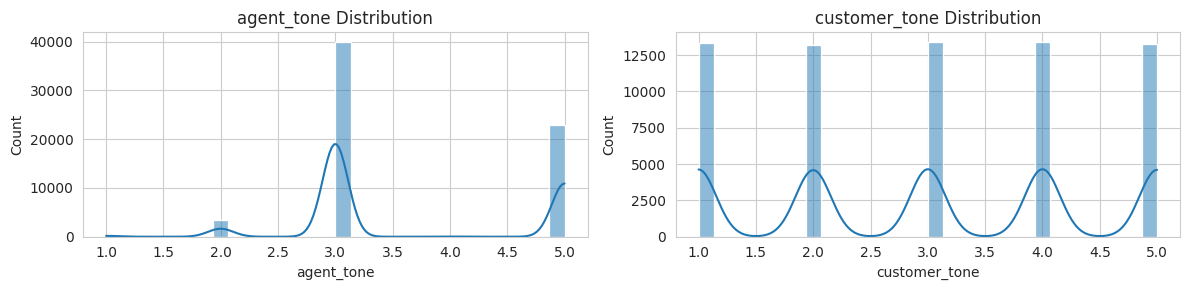

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


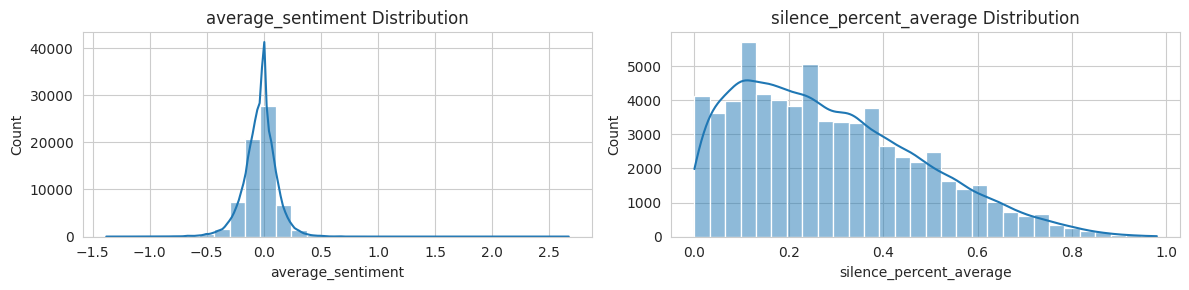

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


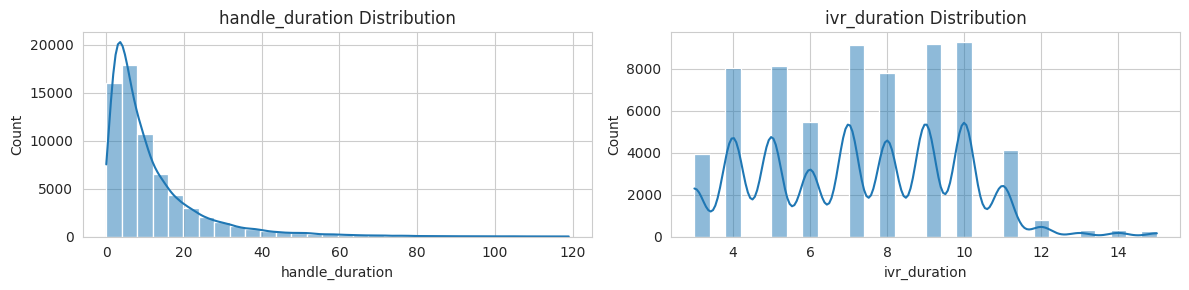

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


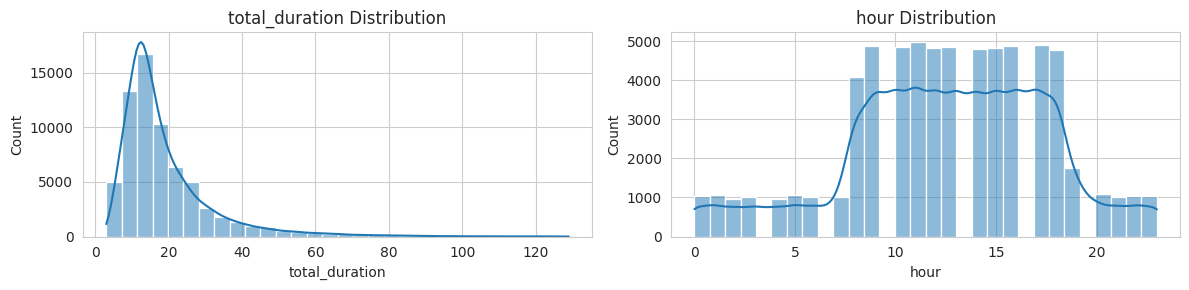

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


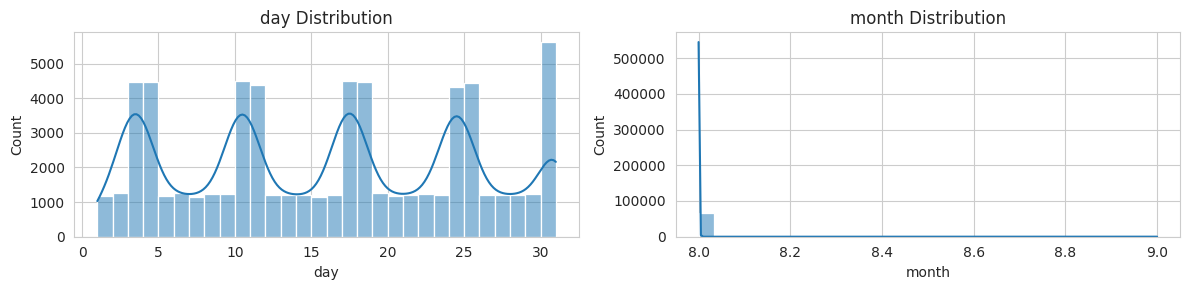

In [116]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
axes = axes.flatten()
columns_to_plot = ['handle_duration', 'ivr_duration', 'silence_percent_average','average_sentiment']
train = callm[num_cols_callm[3:]]
plt.title('Histogram Numerical Columns')
for idx, column in enumerate(train.columns):
    ax = axes[idx % 2]

    sns.histplot(x=column, data=train, bins=30, kde=True, ax=ax)
    
    ax.set_title(f"{column} Distribution")

    if idx % 2 == 1 or idx == len(train.columns) - 1:
        plt.tight_layout()
        plt.show()

        # If not the last column, create a new figure for the next set of plots
        if idx != len(train.columns) - 1:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
            axes = axes.flatten()


#

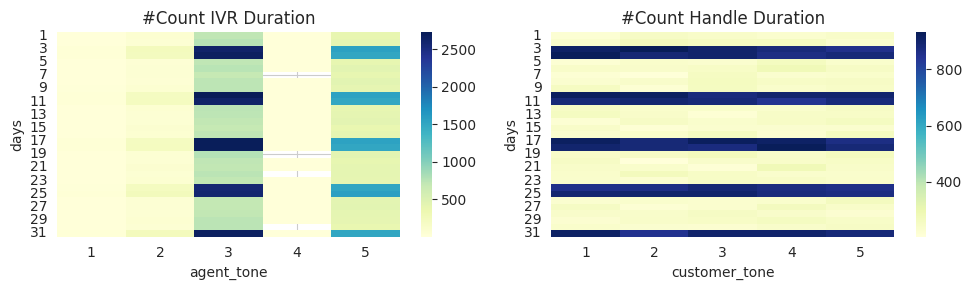

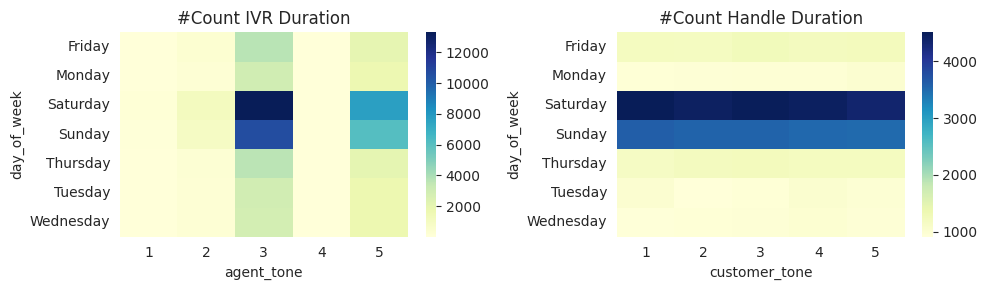

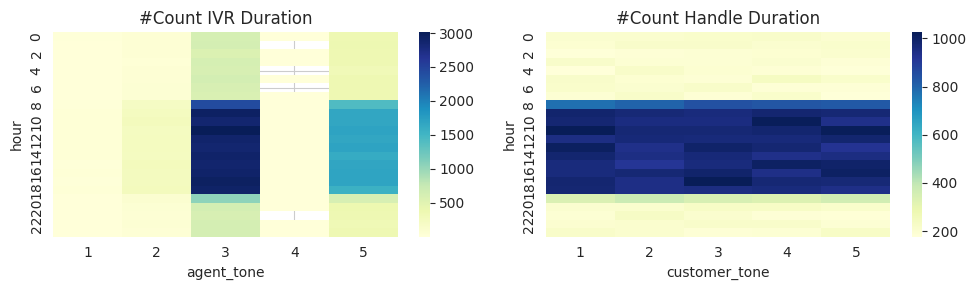

In [145]:
agent_days = callm.groupby(by=['day','agent_tone'])['agent_tone'].value_counts().unstack()
customer_days = callm.groupby(by=['day','customer_tone'])['customer_tone'].value_counts().unstack()
agent_week = callm.groupby(by=['day_of_week','agent_tone'])['agent_tone'].value_counts().unstack()
customer_week = callm.groupby(by=['day_of_week','customer_tone'])['customer_tone'].value_counts().unstack()

agent_hour = callm.groupby(by=['hour','agent_tone'])['agent_tone'].value_counts().unstack()
customer_hour = callm.groupby(by=['hour','customer_tone'])['customer_tone'].value_counts().unstack()

def plotheat(var1, var2, on):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sns.heatmap(var1, ax=axes[0],cmap=cmap)
    axes[0].set_title(f'#Count IVR Duration')
    axes[0].set_ylabel(on)
    sns.heatmap(var2, ax=axes[1],cmap=cmap)
    axes[1].set_title(f'#Count Handle Duration')
    axes[1].set_ylabel(on)

    plt.tight_layout()
    plt.show()
plotheat(agent_days,customer_days,'days')
plotheat(agent_week,customer_week,'day_of_week')

plotheat(agent_hour,customer_hour,'hour')





# High Volume Call Period

In [ ]:
#calls with high volume period
high_volume_conditions = (
    ((callm['day_of_week'] == 'Saturday') | (callm['day_of_week'] == 'Sunday')) &
    (callm['hour'] >= 8) & (callm['hour'] <= 18)
)
callmhv = callm[high_volume_conditions]

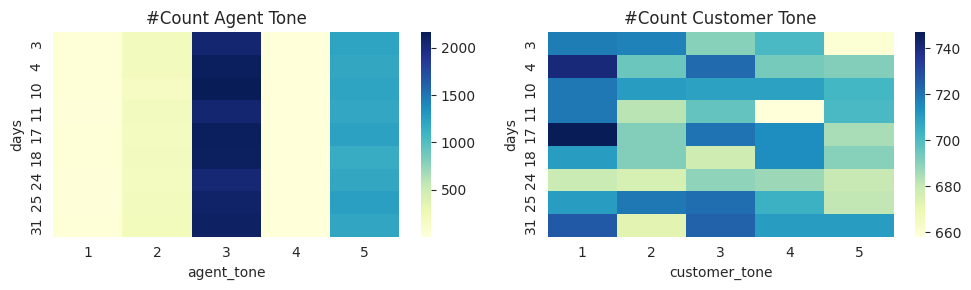

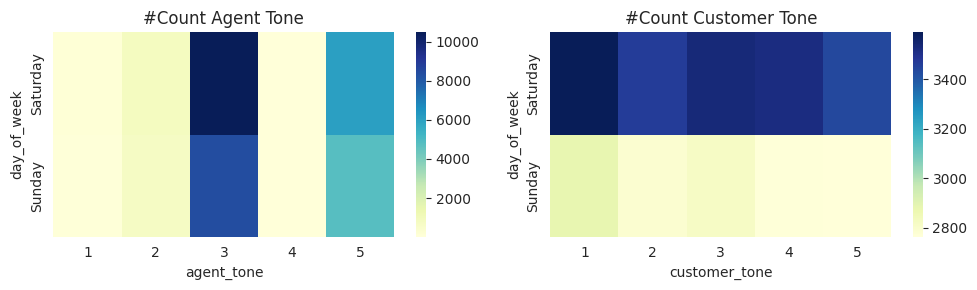

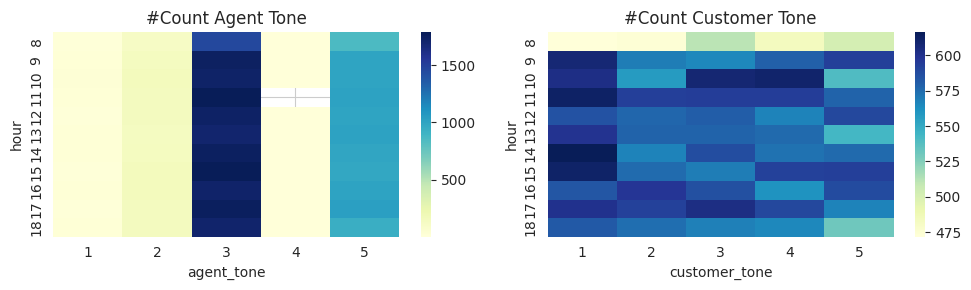

In [233]:
agent_days = callmhv.groupby(by=['day','agent_tone'])['agent_tone'].value_counts().unstack()
customer_days = callmhv.groupby(by=['day','customer_tone'])['customer_tone'].value_counts().unstack()
agent_week = callmhv.groupby(by=['day_of_week','agent_tone'])['agent_tone'].value_counts().unstack()
customer_week = callmhv.groupby(by=['day_of_week','customer_tone'])['customer_tone'].value_counts().unstack()
agent_hour = callmhv.groupby(by=['hour','agent_tone'])['agent_tone'].value_counts().unstack()
customer_hour = callmhv.groupby(by=['hour','customer_tone'])['customer_tone'].value_counts().unstack()

def plotheat(var1, var2, on):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sns.heatmap(var1, ax=axes[0],cmap=cmap)
    axes[0].set_title(f'#Count Agent Tone')
    axes[0].set_ylabel(on)
    sns.heatmap(var2, ax=axes[1],cmap=cmap)
    axes[1].set_title(f'#Count Customer Tone')
    axes[1].set_ylabel(on)

    plt.tight_layout()
    plt.show()
plotheat(agent_days,customer_days,'days')
plotheat(agent_week,customer_week,'day_of_week')

plotheat(agent_hour,customer_hour,'hour')





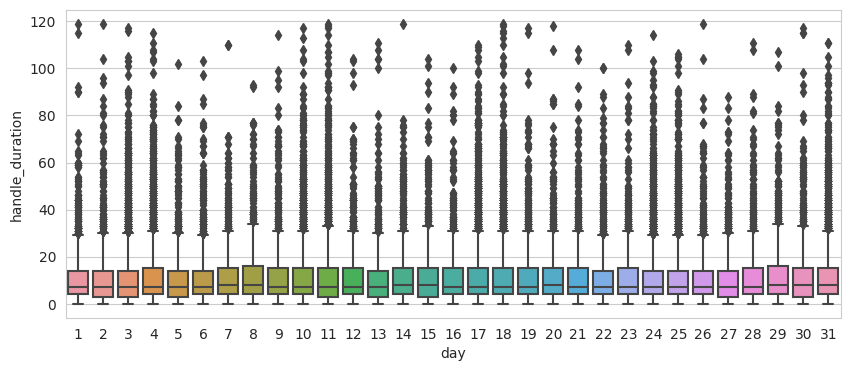

In [141]:
plt.figure(figsize=(10,4))
plt.title('Box Plot Handle Duration')
ax = sns.boxplot(x="day",y='handle_duration',data = callm)
plt.show()


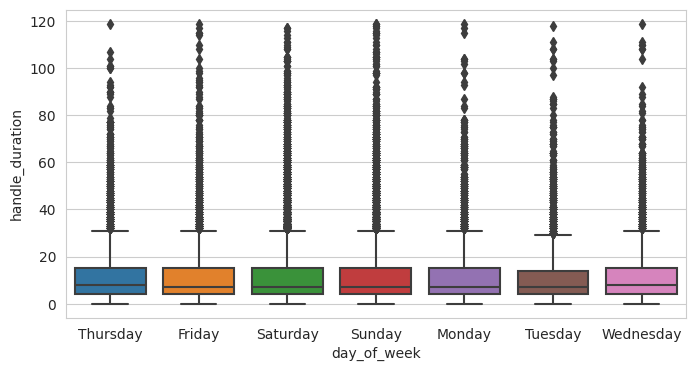

In [151]:
plt.figure(figsize=(8,4))
ax = sns.boxplot(x="day_of_week",y='handle_duration',data = callm)
plt.show()


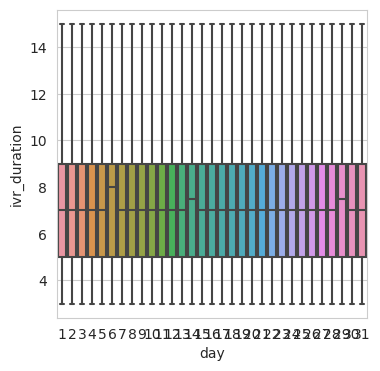

In [152]:
plt.figure(figsize=(16,10))
ax = sns.boxplot(x="day",y='ivr_duration',data = callm)
plt.show()


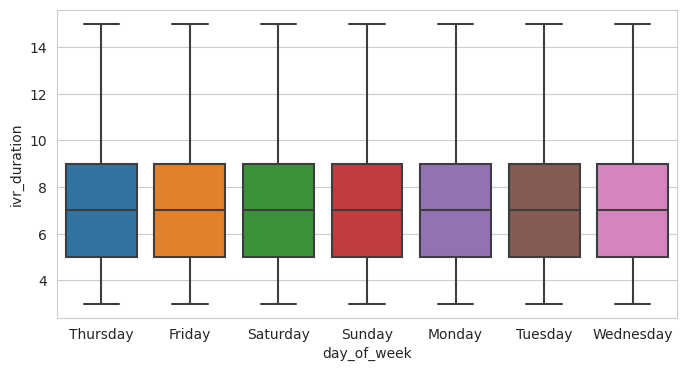

In [153]:
plt.figure(figsize=(8,4))
ax = sns.boxplot(x="day_of_week",y='ivr_duration',data = callm)
plt.show()



high frequency calls are between 8AM to 7PM on Saturdays and Sundays.
Customer are very much frustrated on saturday and sunday

In [223]:
#counting outliers
z_score = (callm['handle_duration'] - callm['handle_duration'].mean()) / callm['handle_duration'].std()

# Count outliers
outliers_z = callm[np.abs(z_score) > 3]
outlier_count_z = outliers_z.shape[0]
print("Number of Outliers: ",outlier_count_z)

Number of Outliers:  1518


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='average_sentiment', ylabel='Count'>

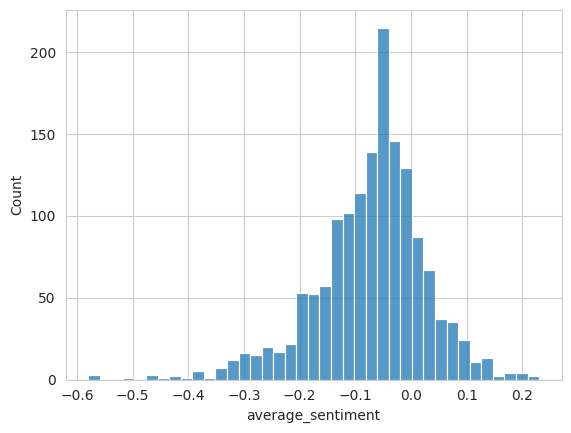

In [297]:
sns.histplot(data = outliers_z, x= 'average_sentiment')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='average_sentiment', ylabel='Count'>

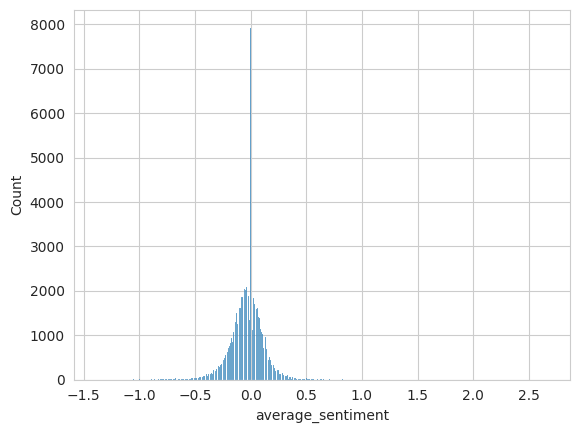

In [298]:
sns.histplot(data = callm, x= 'average_sentiment')

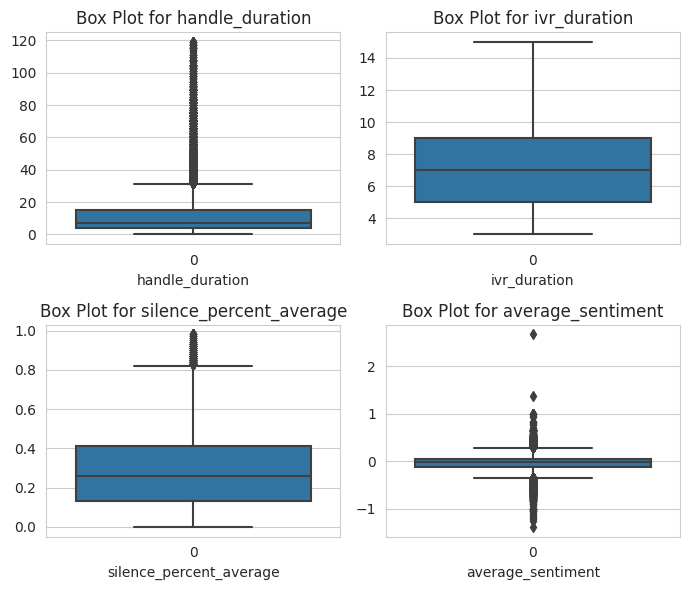

In [106]:

plt.figure(figsize=(7, 6))

columns_to_plot = ['handle_duration', 'ivr_duration', 'silence_percent_average','average_sentiment']

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)  # Creates a 2x2 grid for subplots
    sns.boxplot(data=callm[column])
    plt.title(f'Box Plot for {column}')
    plt.xlabel(column)

plt.tight_layout()  # Adjusts the spacing between subplots
plt.show()


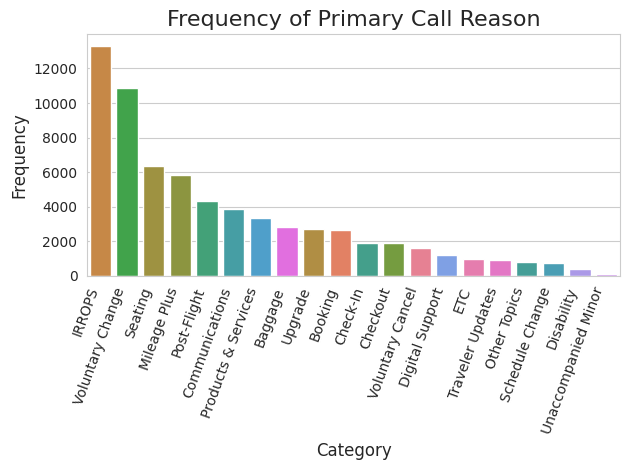

In [58]:
#count plot primary reason

categorical_column = callm['primary_call_reason'].unique()
category_counts = callm['primary_call_reason'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette=color_mapping)
plt.title(f'Frequency of Primary Call Reason', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=70, ha='right')
plt.tight_layout()
plt.show()


In [253]:
num_cols_callm

Index(['call_id', 'customer_id', 'agent_id', 'average_sentiment',
       'silence_percent_average', 'elite_level_code', 'handle_duration',
       'ivr_duration', 'total_duration'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

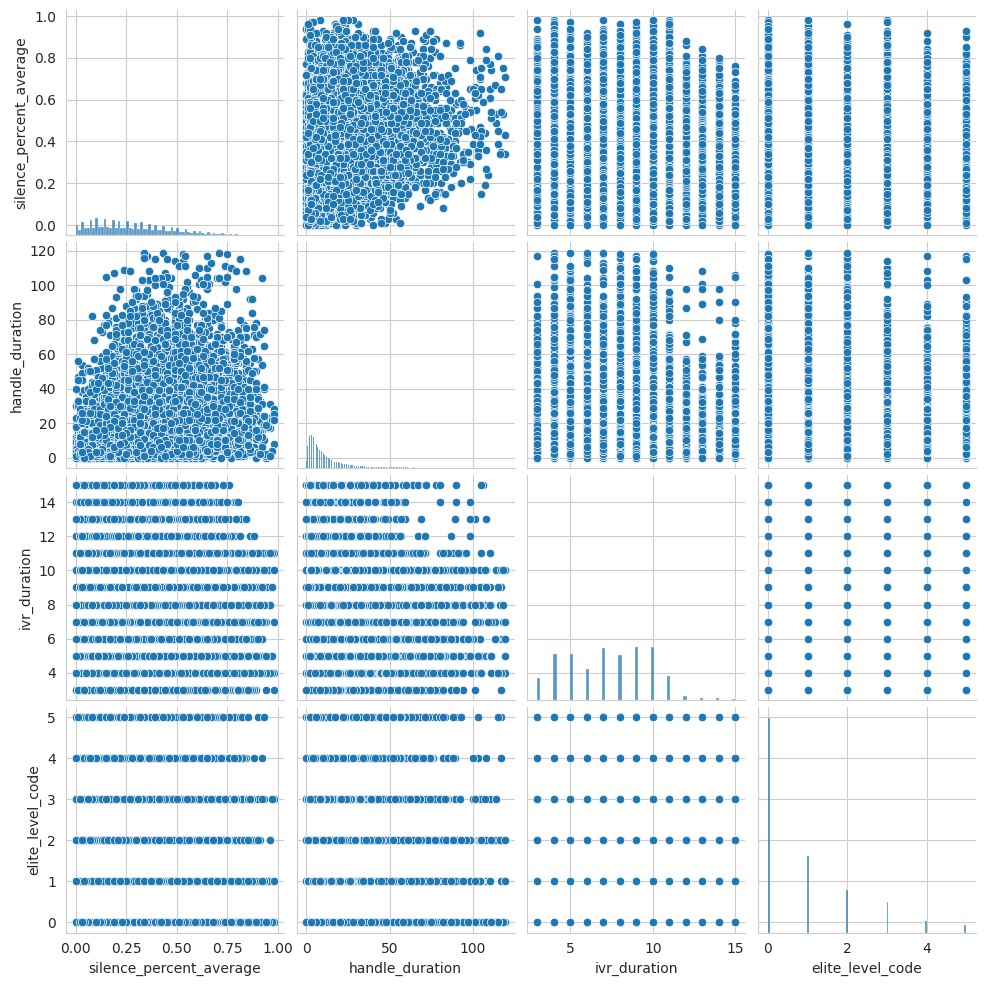

In [235]:
#pairplot
sns.pairplot(callm[['silence_percent_average', 'handle_duration', 'ivr_duration','elite_level_code']])

Text(0.5, 1.0, 'Correlation Matrix Calls')

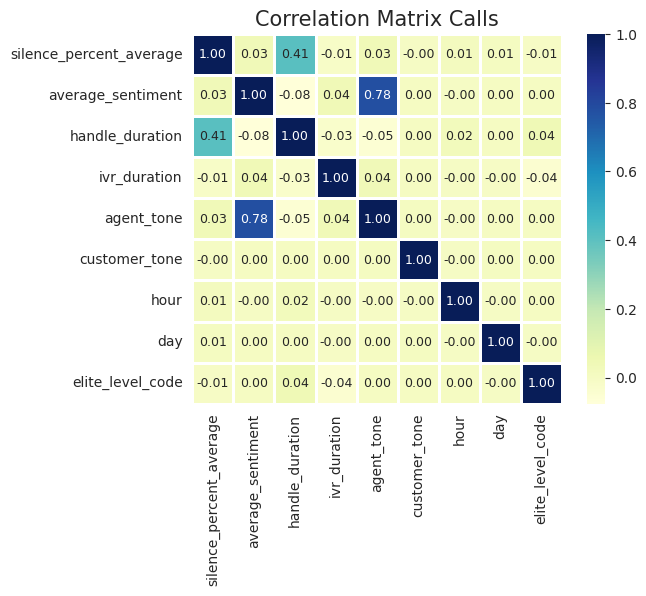

In [143]:
#Correlation Matrix
corr_matrix_train = callm[['silence_percent_average', 'average_sentiment','handle_duration', 'ivr_duration','agent_tone','customer_tone','hour','day','elite_level_code']].corr()

sns.heatmap(corr_matrix_train, annot=True, fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9},cmap=cmap )
plt.title('Correlation Matrix Calls', fontsize=15)



In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [180]:
from sklearn.preprocessing import LabelEncoder

/tmp/ipykernel_30/131546872.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['primary_call_reason']=le.fit_transform(X['primary_call_reason'])
/tmp/ipykernel_30/131546872.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['day_of_week'] = le.fit_transform(X['day_of_week'])


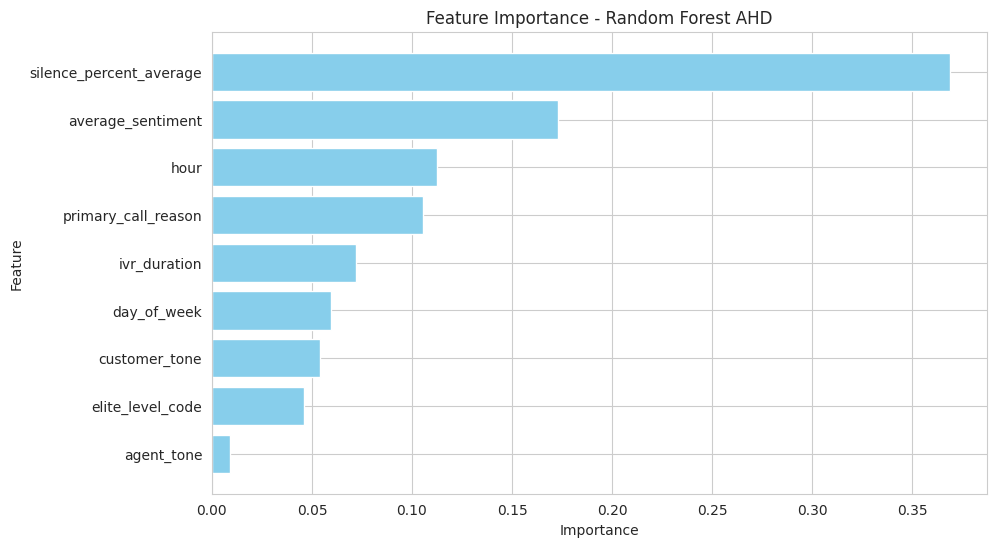

In [212]:
lr = RandomForestRegressor(max_depth=14)
callmml = callm.copy()
le=LabelEncoder()
X = callmml[['silence_percent_average', 'average_sentiment', 'ivr_duration','agent_tone','customer_tone','elite_level_code','primary_call_reason','day_of_week','hour']]
y = callmml['handle_duration']
X['primary_call_reason']=le.fit_transform(X['primary_call_reason'])
X['day_of_week'] = le.fit_transform(X['day_of_week'])
X = pd.get_dummies(X)
X = X.fillna(0)
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2)
lr.fit(X_train,y_train)
importances = lr.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest AHD')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()


In [203]:
from sklearn.linear_model import LinearRegression

/tmp/ipykernel_30/2909508295.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['day_of_week'] = le.fit_transform(X['day_of_week'])


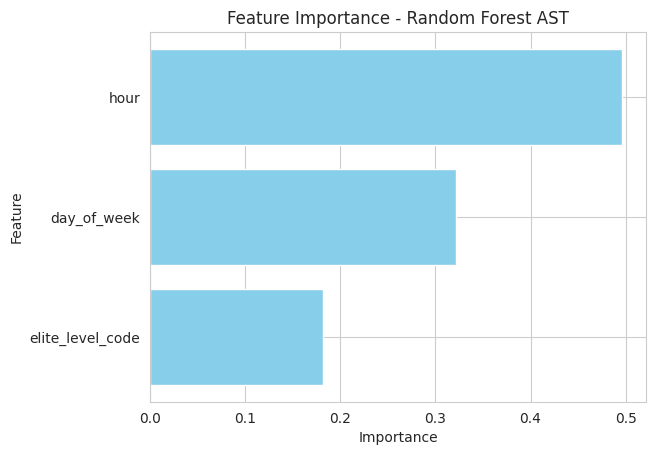

In [211]:
lr = RandomForestRegressor(max_depth=14)
callmml = callm.copy()
le=LabelEncoder()
X = callmml[[ 'elite_level_code','day_of_week','hour']]
y = callmml['ivr_duration']
# X['primary_call_reason']=le.fit_transform(X['primary_call_reason'])
X['day_of_week'] = le.fit_transform(X['day_of_week'])
X = pd.get_dummies(X)
X = X.fillna(0)
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2)
lr.fit(X_train,y_train)
importances = lr.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
# plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest AST')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()



AHT, AST grouped by Time

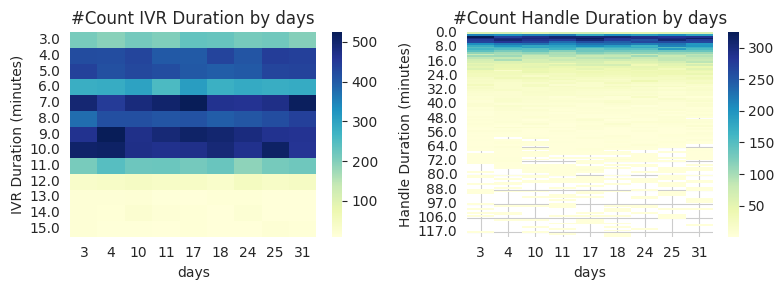

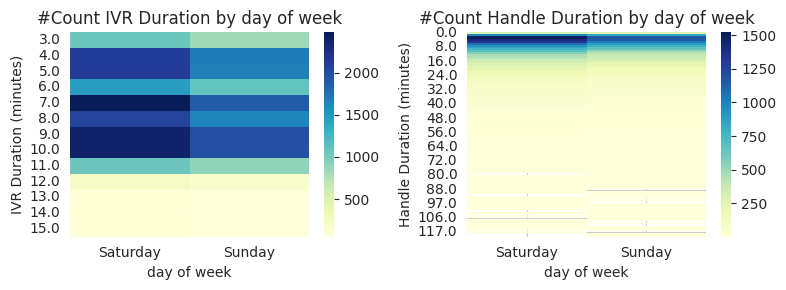

In [231]:

ivr_by_day = callmhv.groupby(['ivr_duration','day'])['ivr_duration'].count().sort_values(ascending=True).unstack()
ahd_by_day = callmhv.groupby(['handle_duration','day'])['handle_duration'].count().sort_values(ascending=True).unstack()
ivr_by_dayofweek = callmhv.groupby(['ivr_duration','day_of_week'])['ivr_duration'].count().sort_values(ascending=True).unstack()
ahd_by_dayofweek = callmhv.groupby(['handle_duration','day_of_week'])['handle_duration'].count().sort_values(ascending=True).unstack()
ivr_by_hour = callmhv.groupby(['ivr_duration','hour'])['ivr_duration'].count().sort_values(ascending=True).unstack()
ahd_by_hour = callmhv.groupby(['handle_duration','hour'])['handle_duration'].count().sort_values(ascending=True).unstack()
def plotheat(var1, var2, on):
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    sns.heatmap(var1, ax=axes[0],cmap=cmap)
    axes[0].set_title(f'#Count IVR Duration by {on}')
    axes[0].set_ylabel('IVR Duration (minutes)')
    axes[0].set_xlabel(on)
    sns.heatmap(var2, ax=axes[1],cmap=cmap)
    axes[1].set_title(f'#Count Handle Duration by {on}')
    axes[1].set_ylabel('Handle Duration (minutes)')
    axes[1].set_xlabel(on)

    plt.tight_layout()
    plt.show()

# plotheat(ivr_by_hour,ahd_by_hour,'hours')
plotheat(ivr_by_day,ahd_by_day,'days')
plotheat(ivr_by_dayofweek,ahd_by_dayofweek,'day of week')



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

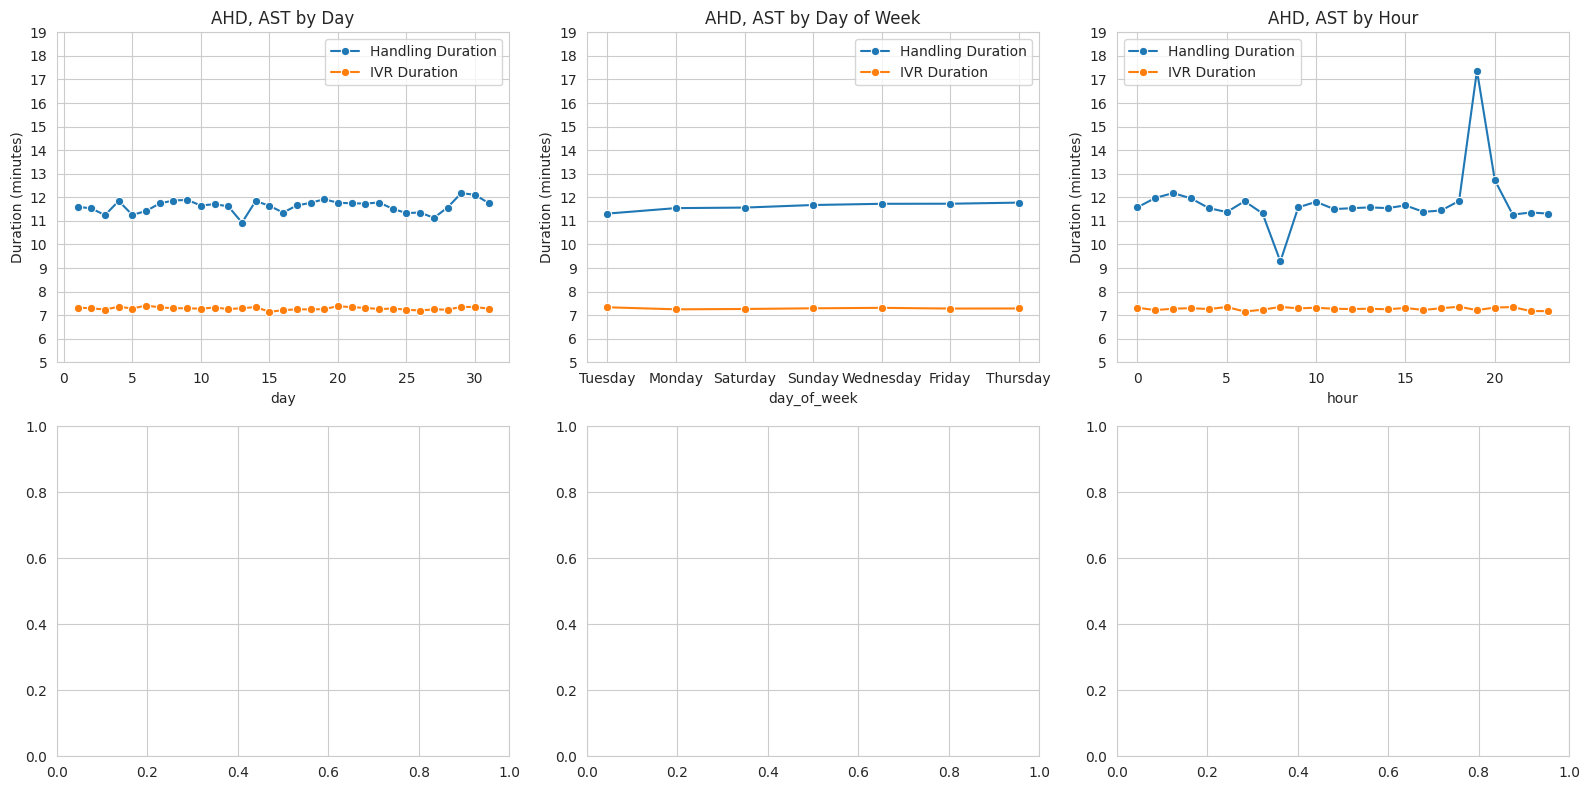

In [174]:

ivr_by_day = callm.groupby(['day'])['ivr_duration'].mean().sort_values(ascending=True)
ahd_by_day = callm.groupby(['day'])['handle_duration'].mean().sort_values(ascending=True)
ivr_by_dayofweek = callm.groupby(['day_of_week'])['ivr_duration'].mean().sort_values(ascending=True)
ahd_by_dayofweek = callm.groupby(['day_of_week'])['handle_duration'].mean().sort_values(ascending=True)
ivr_by_hour = callm.groupby(['hour'])['ivr_duration'].mean().sort_values(ascending=True)
ahd_by_hour = callm.groupby(['hour'])['handle_duration'].mean().sort_values(ascending=True)

import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

sns.lineplot(ax=axes[0, 0], data=ahd_by_day.reset_index(), x='day', y='handle_duration', marker='o', label='Handling Duration')
sns.lineplot(ax=axes[0, 0], data=ivr_by_day.reset_index(), x='day', y='ivr_duration', marker='o', label='IVR Duration')

axes[0, 0].set_title('AHD, AST by Day')
axes[0, 0].set_ylabel('Duration (minutes)')
axes[0, 0].legend() 
axes[0,0].set_yticks([i for i in range(5,20)])

sns.lineplot(ax=axes[0, 1], data=ahd_by_dayofweek.reset_index(), x='day_of_week', y='handle_duration', marker='o', label='Handling Duration')
sns.lineplot(ax=axes[0, 1], data=ivr_by_dayofweek.reset_index(), x='day_of_week', y='ivr_duration', marker='o', label='IVR Duration')

axes[0, 1].set_title('AHD, AST by Day of Week')
axes[0, 1].set_ylabel('Duration (minutes)')
axes[0, 1].legend() 
axes[0, 1].set_yticks([i for i in range(5,20)])
# axes[0, 1].set_xticks(rotation=70)



sns.lineplot(ax=axes[0,2], data=ahd_by_hour.reset_index(), x='hour', y='handle_duration', marker='o', label='Handling Duration')
sns.lineplot(ax=axes[0,2 ], data=ivr_by_hour.reset_index(), x='hour', y='ivr_duration', marker='o', label='IVR Duration')

axes[0, 2].set_title('AHD, AST by Hour')
axes[0, 2].set_ylabel('Duration (minutes)')
axes[0, 2].legend()  
axes[0, 2].set_yticks([i for i in range(5,20)])



plt.tight_layout()
plt.show()


1. Most Frequent calls are on saturday and saturday
2. Everyday call center is most active during 8:00 AM to 6:00PM. The IVR time is also same.
3. So the most high volume period is on saturday and sunday between 8:00 Am to 6:00 PM
4. Employees are currently working efficiently as much as they can, to keep average handling duration around 11~12 minutes every day

In [ ]:
callm

In [176]:
high_volume_conditions = (
    ((callm['day_of_week'] == 'Saturday') | (callm['day_of_week'] == 'Sunday')) &
    (callm['hour'] >= 8) & (callm['hour'] <= 18)
)
#High Volume Data
callmhv = callm[high_volume_conditions]

In [179]:
callmhv.shape


(31561, 20)

Text(0.5, 1.0, 'Correlation Matrix Calls')

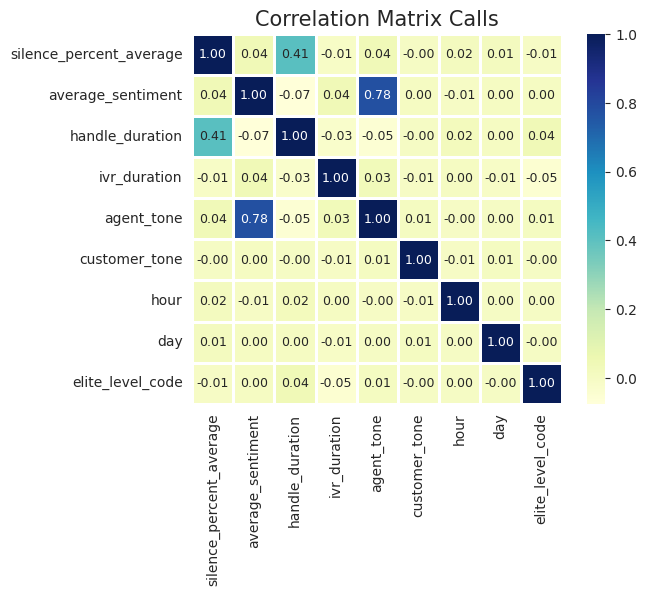

In [178]:
#Correlation Matrix
corr_matrix_train = callmhv[['silence_percent_average', 'average_sentiment','handle_duration', 'ivr_duration','agent_tone','customer_tone','hour','day','elite_level_code']].corr()

sns.heatmap(corr_matrix_train, annot=True, fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9},cmap=cmap )
plt.title('Correlation Matrix Calls', fontsize=15)



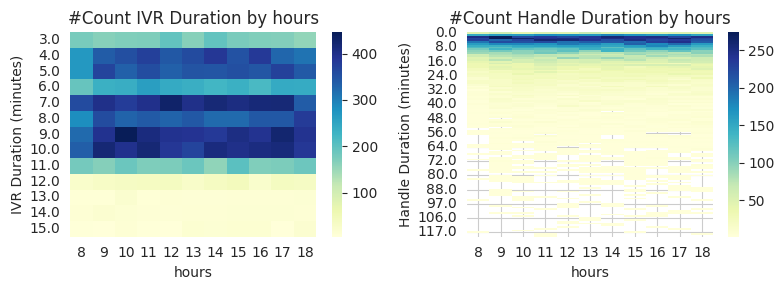

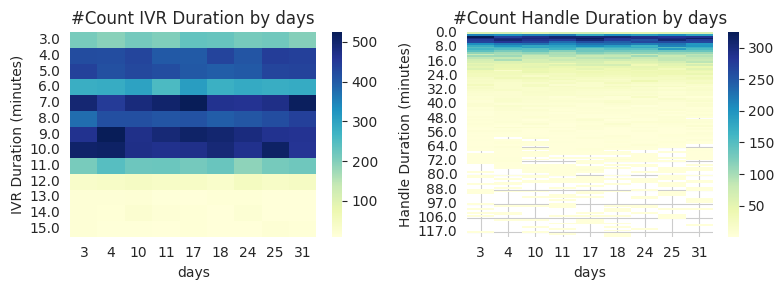

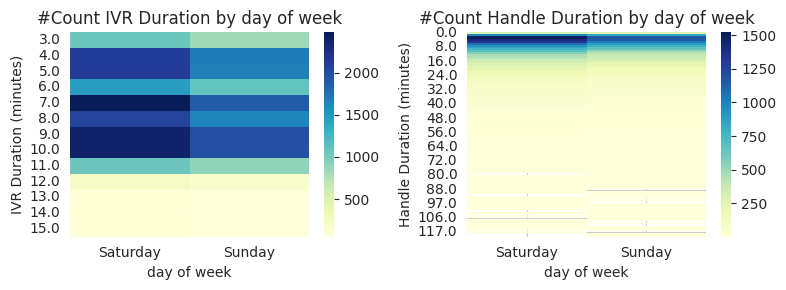

In [177]:

ivr_by_day = callmhv.groupby(['ivr_duration','day'])['ivr_duration'].count().sort_values(ascending=False).unstack()
ahd_by_day = callmhv.groupby(['handle_duration','day'])['handle_duration'].count().sort_values(ascending=False).unstack()
ivr_by_dayofweek = callmhv.groupby(['ivr_duration','day_of_week'])['ivr_duration'].count().sort_values(ascending=False).unstack()
ahd_by_dayofweek = callmhv.groupby(['handle_duration','day_of_week'])['handle_duration'].count().sort_values(ascending=False).unstack()
ivr_by_hour = callmhv.groupby(['ivr_duration','hour'])['ivr_duration'].count().sort_values(ascending=False).unstack()
ahd_by_hour = callmhv.groupby(['handle_duration','hour'])['handle_duration'].count().sort_values(ascending=False).unstack()
plotheat(ivr_by_hour,ahd_by_hour,'hours')
plotheat(ivr_by_day,ahd_by_day,'days')
plotheat(ivr_by_dayofweek,ahd_by_dayofweek,'day of week')


In [188]:
callm[['day_of_week','agent_id']].groupby('day_of_week').nunique().rename(columns={'agent_id': 'number of agents'}).style.background_gradient(cmap)

,number of agents
day_of_week,
Friday,176
Monday,204
Saturday,380
Sunday,373
Thursday,184
Tuesday,171
Wednesday,173


In [191]:
callm[['handle_duration','ivr_duration','day_of_week']].groupby('day_of_week').mean().rename(columns={'handle_duration': 'AHD','ivr_duration':'AST'}).style.background_gradient(cmap)

,AHD,AST
day_of_week,,
Friday,11.728875,7.281832
Monday,11.542728,7.248973
Saturday,11.565477,7.264201
Sunday,11.674548,7.292406
Thursday,11.775856,7.285667
Tuesday,11.310761,7.336129
Wednesday,11.725870,7.312070


In [190]:
callm[['call_id','day_of_week']].groupby('day_of_week').nunique().rename(columns={'call_id': 'Number of Calls'}).style.background_gradient(cmap)

,Number of Calls
day_of_week,
Friday,6071
Monday,4868
Saturday,22252
Sunday,17763
Thursday,6014
Tuesday,4888
Wednesday,4797


In [213]:
palette = sns.color_palette("husl", n_colors=len(callm['primary_call_reason'].unique()))
color_mapping = dict(zip(callm['primary_call_reason'].unique(), palette))


<Axes: xlabel='day'>

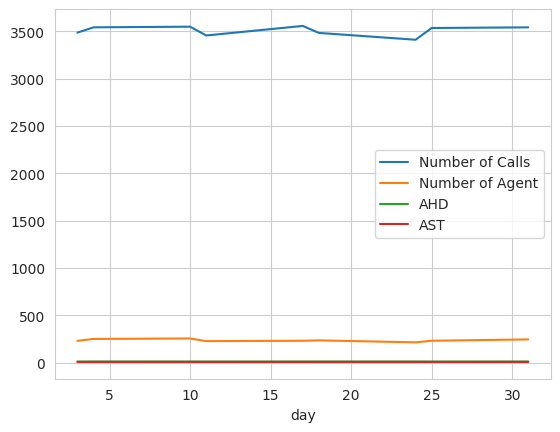

In [211]:
x =callmhv[['call_id','agent_id','day']].groupby('day').nunique().rename(columns={'call_id': 'Number of Calls','agent_id': 'Number of Agent'})
y = callmhv[['handle_duration','ivr_duration','day']].groupby('day').mean().rename(columns={'handle_duration': 'AHD','ivr_duration':'AST'})
pd.concat([x,y]).plot(kind='line')

In [214]:
palette = sns.color_palette("husl", n_colors=len(callm['primary_call_reason'].unique()))
color_mapping = dict(zip(callm['primary_call_reason'].unique(), palette))


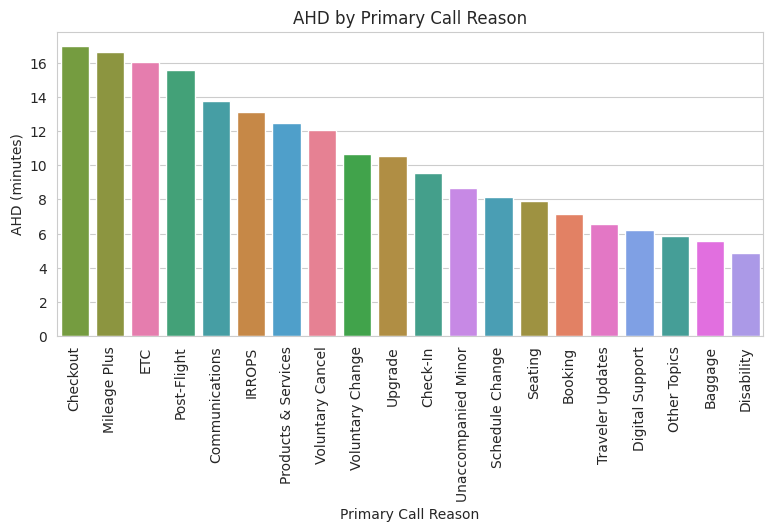

In [216]:
groupedahtast = callm[['primary_call_reason','handle_duration','ivr_duration']].groupby('primary_call_reason').mean().sort_values(ascending=False,by='handle_duration').reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='primary_call_reason', y='handle_duration', data=groupedahtast,palette=color_mapping)
plt.xlabel('Primary Call Reason')
plt.ylabel('AHD (minutes)')
plt.title('AHD by Primary Call Reason')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.tight_layout()

plt.xticks(rotation=90)
plt.show()



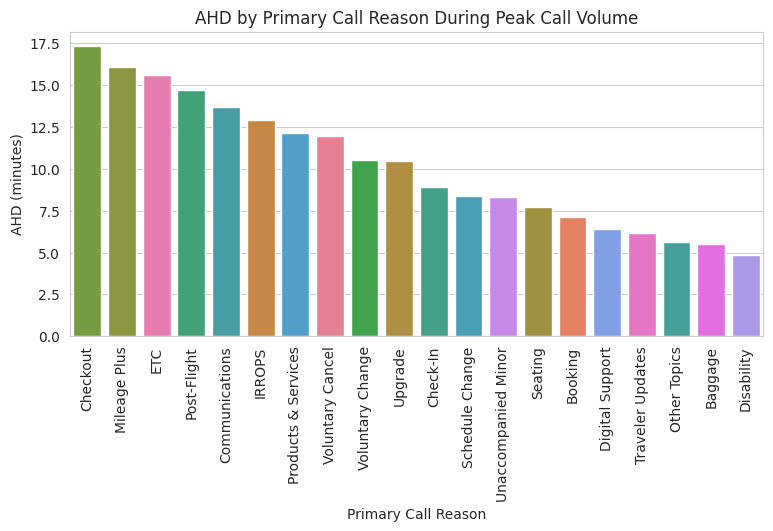

In [220]:
groupedahtast = callmhv[['primary_call_reason','handle_duration','ivr_duration']].groupby('primary_call_reason').mean().sort_values(ascending=False,by='handle_duration').reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='primary_call_reason', y='handle_duration', data=groupedahtast,palette=color_mapping)
plt.xlabel('Primary Call Reason')
plt.ylabel('AHD (minutes)')
plt.title('AHD by Primary Call Reason During Peak Call Volume')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.tight_layout()

plt.xticks(rotation=90)
plt.show()



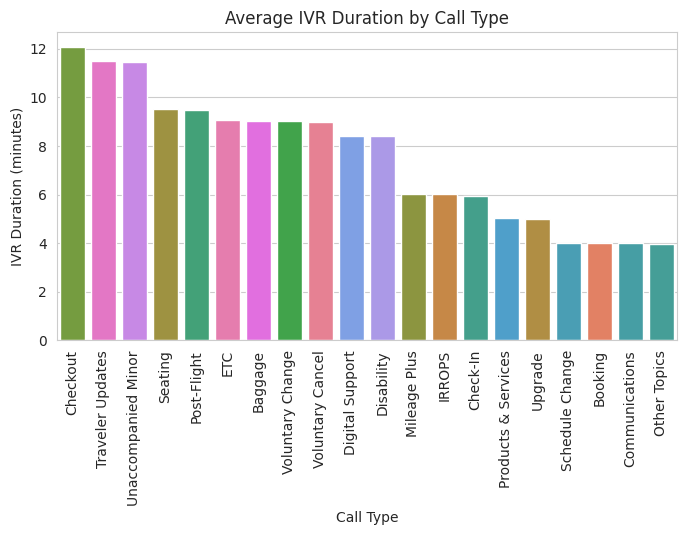

In [218]:
ivr_by_call_type = callm.groupby('primary_call_reason')['ivr_duration'].mean().sort_values(ascending=False)

# Plot IVR duration by call type
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.barplot(x=ivr_by_call_type.index, y=ivr_by_call_type.values,palette=color_mapping)
plt.title('Average IVR Duration by Call Type')
plt.xlabel('Call Type')
plt.ylabel('IVR Duration (minutes)')
plt.xticks(rotation=90)

plt.show()


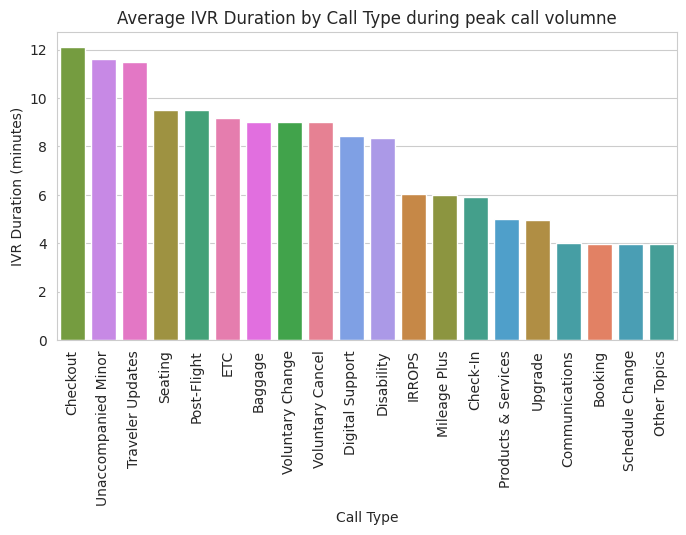

In [221]:
ivr_by_call_type = callmhv.groupby('primary_call_reason')['ivr_duration'].mean().sort_values(ascending=False)

# Plot IVR duration by call type
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.barplot(x=ivr_by_call_type.index, y=ivr_by_call_type.values,palette=color_mapping)
plt.title('Average IVR Duration by Call Type during peak call volumne')
plt.xlabel('Call Type')
plt.ylabel('IVR Duration (minutes)')
plt.xticks(rotation=90)

plt.show()


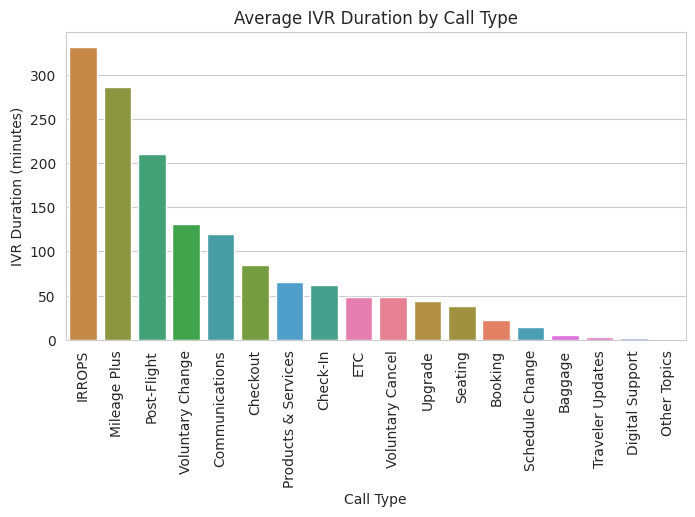

In [226]:
ivr_by_call_type = outliers_z.groupby('primary_call_reason')['handli'].count().sort_values(ascending=False)

# Plot IVR duration by call type
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.barplot(x=ivr_by_call_type.index, y=ivr_by_call_type.values,palette=color_mapping)
plt.title('Average IVR Duration by Call Type')
plt.xlabel('Call Type')
plt.ylabel('IVR Duration (minutes)')
plt.xticks(rotation=90)

plt.show()


Additionally, could you quantify the percentage difference between the average handling time for the most frequent and least frequent call reasons?


In [239]:
def calculatepercent_diff(df, col, mf, lf):
    aht_mf = df[df['primary_call_reason'] == mf][col].mean()  # Average AHT for Checkout
    aht_lf = df[df['primary_call_reason'] == lf][col].mean()  # Average AHT for Disability

    percentage_difference = ((aht_mf - aht_lf) / aht_lf) * 100

    print(f'Average {col} for {mf}: {aht_mf:.2f}')
    print(f'Average {col} for {lf}: {aht_lf:.2f}')
    print(f'Percentage Difference in {col}: {percentage_difference:.2f}%')

    

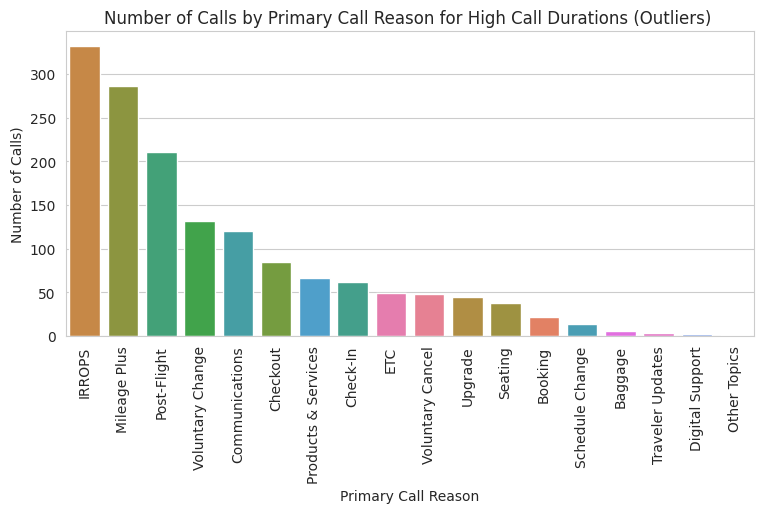

In [240]:
groupedahtast = outliers_z[['primary_call_reason','handle_duration','ivr_duration']].groupby('primary_call_reason').count().sort_values(ascending=False,by='handle_duration').reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='primary_call_reason', y='handle_duration', data=groupedahtast,palette=color_mapping)
plt.xlabel('Primary Call Reason')
plt.ylabel('Number of Calls)')
plt.title('Number of Calls by Primary Call Reason for High Call Durations (Outliers) ')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.tight_layout()

plt.xticks(rotation=90)
plt.show()



# Percent Difference

In [241]:
calculatepercent_diff(callm, 'handle_duration','Checkout','Disability')

Average handle_duration for Checkout: 16.95
Average handle_duration for Disability: 4.87
Percentage Difference in handle_duration: 248.11%


In [242]:
calculatepercent_diff(callm, 'ivr_duration','Checkout','Other Topics')

Average ivr_duration for Checkout: 12.08
Average ivr_duration for Other Topics: 3.98
Percentage Difference in ivr_duration: 203.54%


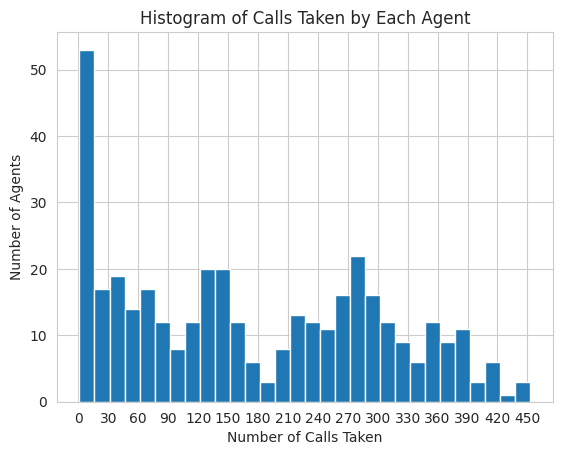

In [38]:
agent_counts = callm['agent_id'].value_counts()
plt.title('Histogram of Calls Taken by Each Agent')
agent_counts.plot(kind='hist',bins=30)
plt.xticks(ticks=range(0, int(agent_counts.max()) + 1, 30))
plt.ylabel('Number of Agents')
plt.xlabel('Number of Calls Taken')
plt.show()

In [41]:
print("Average Number of Calls taken by an angent in a month:", np.mean(agent_counts.values))

Average Number of Calls taken by an angent in a month: 174.02872062663187


In [ ]:
#We are given a month of data from, 1 september to 1 october
#There are 383 agents & have taken 66653 calls. per agent 186 calls in a month.
#Key Drivers for Long AHT includes silent_percent_average, small bit of agent tone, , some categories of primary reason which are discovered later.
# If we have flight timing data such as delay information

In [316]:
callm.to_csv("train.csv", index=False)
test.to_csv("test.csv",index=False)

#Tex

In [244]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, Word

# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [391]:
pd.DataFrame(train['length1'].describe()).rename({'length1': "Number of Words"},axis=1).style.background_gradient(cmap=cmap
                                                                   )

,Number of Words
count,71810.000000
mean,500.854477
std,104.101949
min,30.000000
25%,426.000000
50%,490.000000
75%,565.000000
max,844.000000


In [253]:
callm[['handle_duration','pause']].corr()

,handle_duration,pause
handle_duration,1.000000,0.006731
pause,0.006731,1.000000


# Text Analysis

In [280]:
import re
train = pd.read_csv('/kaggle/input/calls-skyhack/callsf0d4f5a.csv', usecols=['call_id','call_transcript'])

In [303]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [301]:
!python -m nltk.downloader all


/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downlo

In [309]:

# from tqdm import tqdm
# tqdm.pandas()
train['pauses']=train['call_transcript'].progress_apply(lambda x: len(re.findall(r'\*(.*?)\*', x)))
train['call_transcript1'] = train['call_transcript'].progress_apply(clean_text)
train['call_transcript2'] = train['call_transcript1'].progress_apply(remove_stopwords)
train['call_transcript3'] = train['call_transcript2'].progress_apply(extract_verbs)
train['call_transcript4'] = train['call_transcript3'].apply(lambda x: ' '.join(x))

100%|██████████| 71810/71810 [32:05<00:00, 37.30it/s]


In [315]:
# train['length']  = train['call_transcript3'].apply(lambda x: len(x))
train['length1']  = train['call_transcript'].apply(lambda x: len(x.split()))

In [433]:
train['length'].describe()

count    71810.000000
mean        59.522295
std         13.822837
min          3.000000
25%         50.000000
50%         58.000000
75%         68.000000
max        131.000000
Name: length, dtype: float64

In [308]:
def clean_text(text):
    sentences = nltk.sent_tokenize(text)
    # Remove the first sentence
    if len(sentences) > 1:
        text = ' '.join(sentences[1:])
    else:
        text = ''
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\b(agent|customer)\b', '', text, flags=re.IGNORECASE)
    return text
def remove_stopwords(text):
    words = text.split()
    sw = nltk.corpus.stopwords.words('english')
    words = [word for word in words if word not in sw]
    return ' '.join(words)
def extract_verbs(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    verbs = [word for word, pos in tagged if pos.startswith('VB')]
    return verbs



In [266]:
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [331]:
train.to_csv('training.csbv')

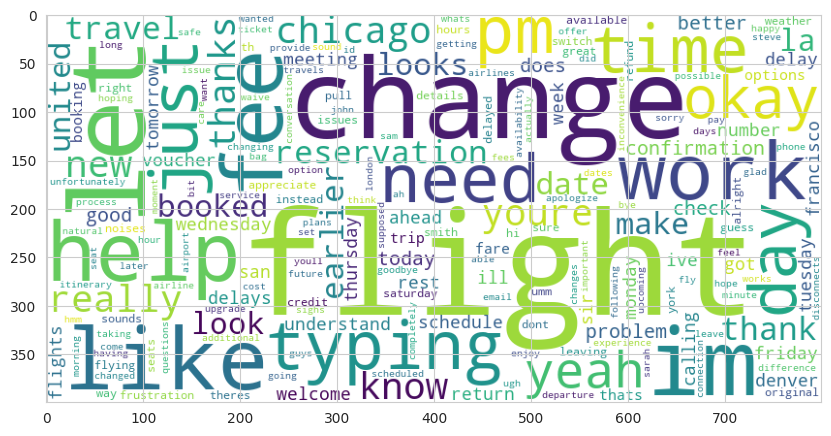

In [398]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

least_frequent = 'Disability' 
transcripts = train['call_transcript1']
tfidf = TfidfVectorizer(stop_words='english', max_features=1000) 
tfidf_matrix = tfidf.fit_transform(transcripts)

feature_names = tfidf.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1

word_scores = dict(zip(feature_names, tfidf_scores))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)


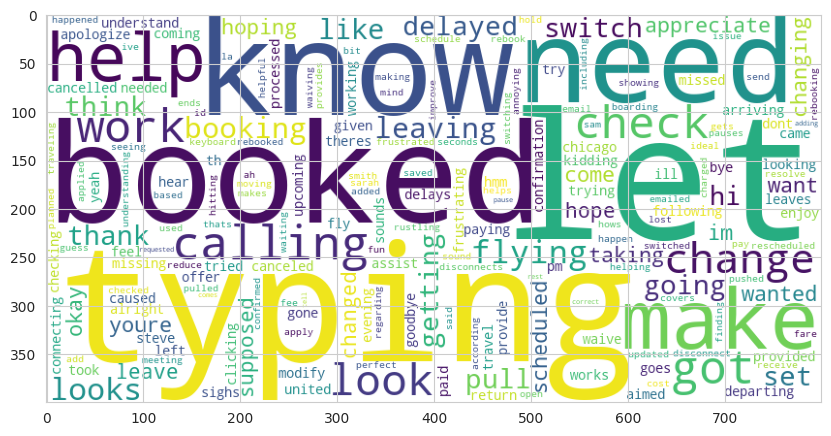

In [392]:
most_frequent_class = 'IRROPS' 
transcripts = train.iloc[callm[callm['primary_call_reason'] == most_frequent_class]['call_id'].index]['call_transcript4']

tfidf = TfidfVectorizer(stop_words='english', max_features=1000) 
tfidf_matrix = tfidf.fit_transform(transcripts)

feature_names = tfidf.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1

word_scores = dict(zip(feature_names, tfidf_scores))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)


In [404]:
mapping = {
        'Mileage Plus': 'Mileage Plus',
        'Mileage   Plus': 'Mileage Plus',
        'Mileage  Plus': 'Mileage Plus',
        'Mileage Plus  ': 'Mileage Plus',
        'Voluntary Cancel': 'Voluntary Cancel',
        'Voluntary  Cancel': 'Voluntary Cancel',
        'Voluntary Cancel  ': 'Voluntary Cancel',
        'Voluntary Change': 'Voluntary Change',
        'Voluntary  Change': 'Voluntary Change',
        'Voluntary   Change': 'Voluntary Change',
        'Voluntary Change  ': 'Voluntary Change',
        'Booking': 'Booking',
        'Booking  ': 'Booking',
        'IRROPS': 'IRROPS',
        'IRROPS  ': 'IRROPS',
        'Post Flight': 'Post-Flight',
        'Post-Flight  ': 'Post-Flight',
        'Post-Flight': 'Post-Flight',
        'Schedule Change': 'Schedule Change',
        'Schedule Change  ': 'Schedule Change',
        'Seating': 'Seating',
        'Seating  ': 'Seating',
        'Baggage': 'Baggage',
        'Baggage  ': 'Baggage',
        ' Baggage' : 'Baggage',
        'Check In': 'Check-In',
        'Check-In  ': 'Check-In',
        'Checkout  ':'Checkout',
        'Other Topics': 'Other Topics',
        'Other  Topics': 'Other Topics',
        'Other Topics  ': 'Other Topics',
        'Products And Services': 'Products & Services',
        'Products and Services': 'Products & Services',
        'Products and Services  ': 'Products & Services',
        'Products & Services  ': 'Products & Services',
        'Digital Support': 'Digital Support',
        'Digital   Support': 'Digital Support',
        'Digital  Support': 'Digital Support',
        'Digital Support  ':'Digital Support',
        'Etc': 'ETC',
        'Etc  ': 'ETC',
        'ETC  ': 'ETC',
        'Upgrade  ':'Upgrade',
        'Traveler Updates': 'Traveler Updates',
        'Traveler   Updates': 'Traveler Updates',
        'Traveler  Updates': 'Traveler Updates',
        'Traveler Updates  ': 'Traveler Updates',
        'Communications': 'Communications',
        'Communications  ': 'Communications',
        'Unaccompanied Minor': 'Unaccompanied Minor',
        'Unaccompanied Minor  ': 'Unaccompanied Minor',
        'Disability': 'Disability',
        'Disability  ': 'Disability'
    }


In [409]:
X = pd.merge(train[['call_id','call_transcript2']],reason,on='call_id', how='inner')
testr = pd.merge(train[['call_id','call_transcript2']],test,on='call_id', how='inner')[['call_id','call_transcript2']]
Xt = X['call_transcript2']
y = X['primary_call_reason'].replace(mapping)
X_train, X_test, y_train, y_test = train_test_split(Xt,y,test_size=0.2, random_state=1)
tfidf = TfidfVectorizer(stop_words='english', max_features=1000) 
X_trainvec = tfidf.fit_transform(X_train)
X_testvec = tfidf.transform(X_test)



In [410]:
clf = DecisionTreeClassifier(max_depth=15).fit(X_trainvec,y_train)
y_pred = clf.predict(X_testvec)

In [431]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

            Baggage       0.00      0.00      0.00       565
            Booking       0.00      0.00      0.00       517
           Check-In       0.00      0.00      0.00       382
           Checkout       0.00      0.00      0.00       389
     Communications       0.00      0.00      0.00       760
    Digital Support       0.00      0.00      0.00       237
         Disability       0.00      0.00      0.00        72
                ETC       0.00      0.00      0.00       182
             IRROPS       0.21      0.74      0.32      2665
       Mileage Plus       0.12      0.01      0.02      1205
       Other Topics       0.00      0.00      0.00       168
        Post-Flight       0.23      0.01      0.01       853
Products & Services       0.50      0.00      0.01       684
    Schedule Change       0.00      0.00      0.00       156
            Seating       0.12      0.01      0.02      1260
   Traveler Updates    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**#Even LSTM model giving same accuracy in validation**

# Submission

In [426]:
testrvec = tfidf.transform(testr['call_transcript2'])
y_subm = clf.predict(testrvec)
testr['primary_call_reason']=y_subm
testr[['call_id','primary_call_reason']].to_csv('test.csv',index=False)